In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import pickle
import seaborn as sns

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [60]:
from simulations.scenarios import *
from simulations.utils import Context
from simulations.parse_enron import Message

In [61]:
sns.set_context("paper", font_scale=1.5)
sns.set_style("white")
sns.set_palette('cubehelix', n_colors=3)

In [62]:
parsed_logs_folder = 'Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))
log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))[:2000]

In [63]:
context = Context(log, social_graph)

In [64]:
def visualize_propagation(scenario_name, kp, hp=None):
    kp = kp[['Stale', 'Updated']]
    
    kp.plot.area()
    plt.legend(frameon=True)
    plt.title("%s — Encryption keys propagation" % scenario_name)
    plt.xlabel("Emails sent")
    plt.ylabel("Link Key status")
    
    plt.savefig(scenario_name.lower().replace(' ', '_') + '_key_propagation.pdf')

    if hp is not None:
        hp = hp[['Stale', 'Updated']]
        hp.plot.area()
        plt.legend(frameon=True)
        plt.title("%s — Head propagation" % scenario_name)
        plt.xlabel("Emails sent")
        plt.ylabel("Link Head status")

        plt.savefig(scenario_name.lower().replace(' ', '_') + '_head_propagation.pdf')

In [65]:
def visualize_encryption_status_history(scenario_name, es, batch_size=500):
    batch_stats_data = pd.DataFrame(columns=['Stale key', 'Encrypted', 'Plaintext'])
    for i in range(0, len(es), batch_size):
        batch = es[i:i+batch_size].dropna()
        batch_stats = batch.value_counts()
        if len(batch_stats) == 0:
            continue
            
        batch_stats_data.loc[i] = list(
            batch_stats[[EncStatus.stale, EncStatus.encrypted, EncStatus.plaintext]] \
            / batch_stats.sum() * 100)

    batch_stats_data.plot.area()

    plt.legend(frameon=True)
    plt.title("%s — Encryption status" % scenario_name)
    plt.xlabel("Email sent")
    plt.ylabel("Emails traffic, %")
    plt.ylim(0, 100)
    
    plt.savefig(scenario_name.lower().replace(' ', '_') + '_traffic.pdf')

In [69]:
static_params = SimulationParams(chain_update_buffer_size=1)
dynamic_params = SimulationParams(chain_update_buffer_size=1, key_update_every_nb_sent_emails=50)

In [70]:
with static_params.as_default():
    encryption_status_data, sender_cache_data, recipient_store_data, bandwidth_data = \
            simulate_public_claimchain(context)

Simulating the ClaimChain with public claims:
SimulationParams(chain_update_buffer_size=1, key_update_every_nb_sent_emails=None)
0
1000
Emails: Sent: 231, Encrypted: 2


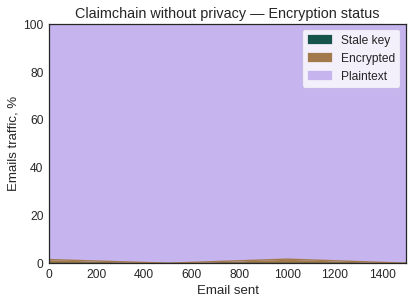

In [71]:
visualize_encryption_status_history('Claimchain without privacy', encryption_status_data)

In [54]:
with dynamic_params.as_default():
    encryption_status_data, sender_cache_data, recipient_store_data, bandwidth_data = \
            simulate_public_claimchain(context)

Simulating the ClaimChain with public claims:
SimulationParams(chain_update_buffer_size=5, key_update_every_nb_sent_emails=50)
0
1000
Emails: Sent: 231, Encrypted: 19


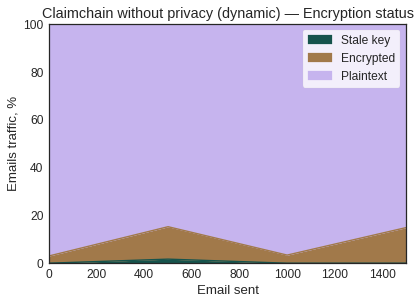

In [55]:
visualize_encryption_status_history('Claimchain without privacy (dynamic)', encryption_status_data)

In [72]:
with static_params.as_default():
    encryption_status_data, sender_cache_data, recipient_store_data, bandwidth_data = \
            simulate_private_claimchain(context)

Simulating the ClaimChain with public claims:
SimulationParams(chain_update_buffer_size=1, key_update_every_nb_sent_emails=None)
0
1000
Emails: Sent: 231, Encrypted: 98


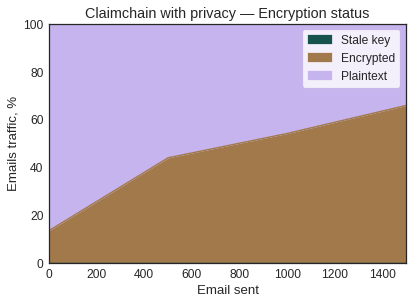

In [73]:
visualize_encryption_status_history('Claimchain with privacy', encryption_status_data)